In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch as tch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models

import os
print(os.listdir("/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"))

device = tch.device("cuda:0" if tch.cuda.is_available() else "cpu")
print("Current  Device:",device)

['Uninfected', 'Parasitized']
Current  Device: cuda:0


In [3]:
image_folder = "/kaggle/input/cell-images-for-detecting-malaria/cell_images/cell_images"

#Define Classes for the title
classes= ['Parasitized', 'Uninfected']

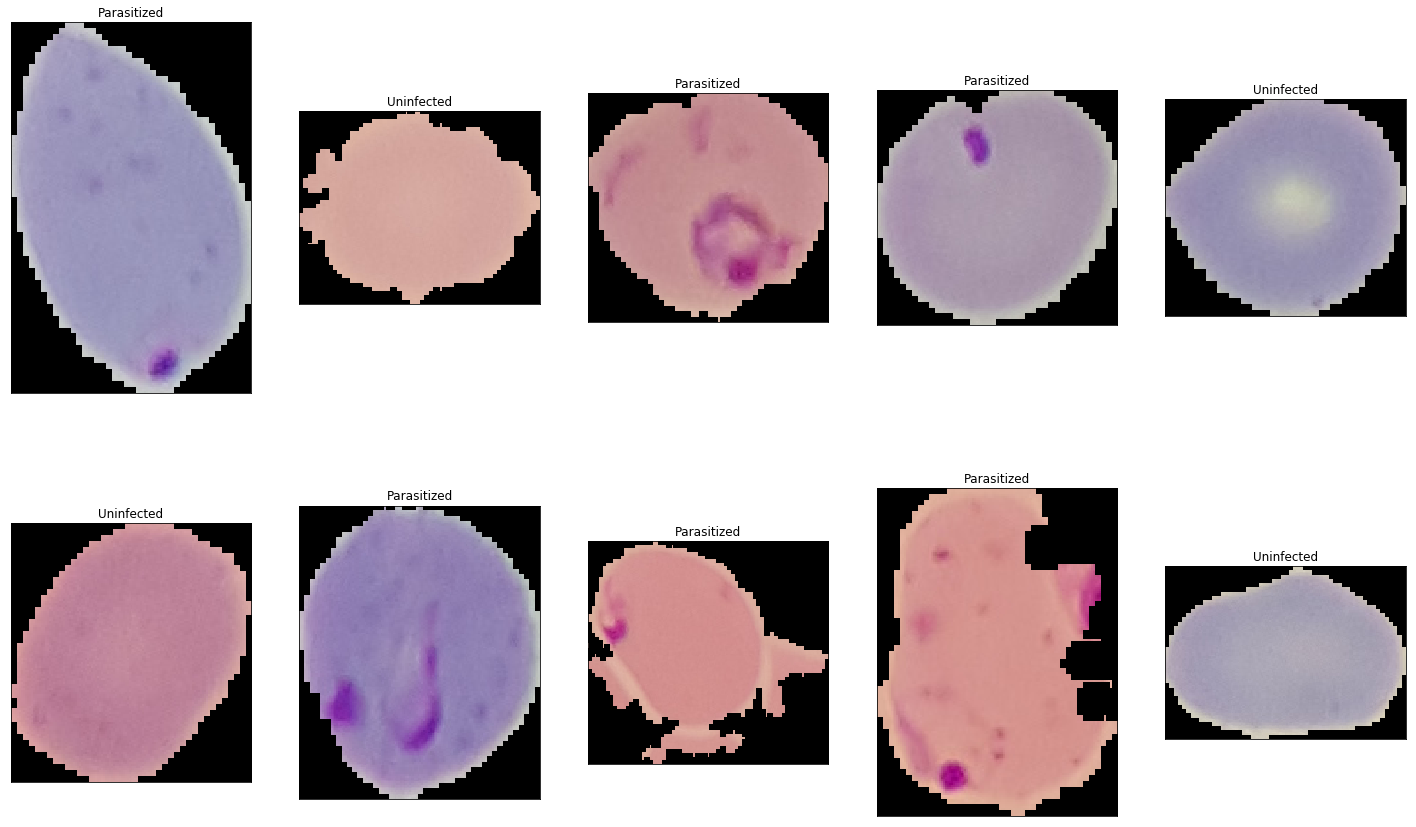

In [4]:
#Import the images data with just Tensor Transformation for viewing the images
image_data = datasets.ImageFolder(root=image_folder,transform = transforms.ToTensor())

#Create a place holder for images and labels to study
image_list= []
title_list = []

#Create a random list if Prasitized nad Uninfected (limiting samples to 10)
np.random.seed(2019)
for i in np.random.choice(range(1,len(image_data)),10):
    image_list.append(image_data[i][0].numpy().transpose())
    title_list.append(classes[image_data[i][1]])

fig = plt.figure(figsize=(25, 15))
for i,(image,title) in enumerate(zip(image_list,title_list)):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=title)
    plt.imshow(image)
plt.show()    

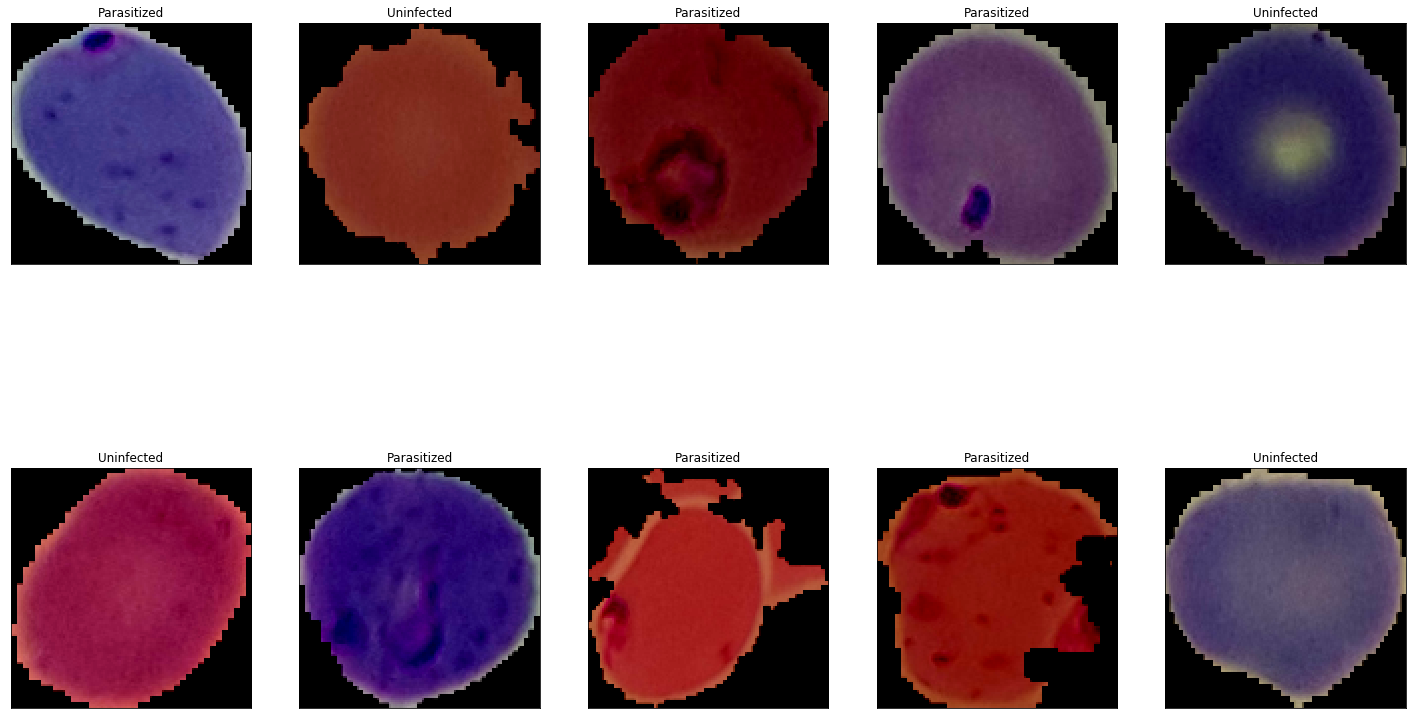

In [5]:
#Import the images data with just Tensor Transformation for viewing the images
transformation  = transforms.Compose([transforms.Resize((120,120)),
                                     transforms.ColorJitter(0.1),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])


image_data = datasets.ImageFolder(root=image_folder,transform = transformation)

#Create a place holder for images and labels to study
image_list= []
title_list = []

#Create a random list if Prasitized nad Uninfected (limiting samples to 10)
np.random.seed(2019)
for i in np.random.choice(range(1,len(image_data)),10):
    image_list.append(image_data[i][0].numpy().transpose())
    title_list.append(classes[image_data[i][1]])

fig = plt.figure(figsize=(25, 15))
for i,(image,title) in enumerate(zip(image_list,title_list)):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[], title=title)
    plt.imshow(image)
plt.show()    

In [6]:
len(image_data)

27558

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class Malaria(nn.Module):
    def __init__(self):
        super(Malaria, self).__init__()
    
        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size = 5,stride =1, padding =2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)            
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32,kernel_size = 5,stride =1, padding =2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)            
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64,kernel_size = 3,stride =1, padding =1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)            
        )    

        self.layer4 = nn.Sequential(
            nn.Conv2d(64,128,kernel_size = 3,stride =1, padding =1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=1)            
        )    
        
        self.fc1 = nn.Linear(128*14*14, 512)
        self.fc2 = nn.Linear(512,128)
        self.fc3 = nn.Linear(128,2)    
        self.Dropout = nn.Dropout2d(0.2)

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)        
        out = self.layer4(out)                
        out = out.view(out.size(0),-1)
        #Using Dropout Regularization
        out = self.fc1(out)
        out = F.relu(out)
        out = self.Dropout(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.Dropout(out)    
        out = self.fc3(out)
        return(out)

In [8]:
model = Malaria()
model.to(device)
loss_function = nn.CrossEntropyLoss()
learning_rate = 0.001
#Using Adams Optimization
optimizer = tch.optim.Adam(model.parameters(),lr= learning_rate)

In [9]:
print(model)

Malaria(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNo

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

test_size= 0.2
samples = len(image_data)
indices = list(range(samples))
np.random.shuffle(indices)
train_len  =  int(np.floor(samples * (1-test_size)))
train_index, test_index = indices[:train_len], indices[train_len:]

train_sampler,test_sampler = SubsetRandomSampler(train_index),SubsetRandomSampler(test_index)

train_loader = DataLoader(image_data,sampler= train_sampler,batch_size = 64)
test_loader = DataLoader(image_data, sampler= test_sampler,batch_size = 64, )

In [11]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss= 0.0
    #Explicitly start model training
    model.train()
    
    for i, (images,labels) in enumerate(train_loader):
        images,labels = images.to(device),labels.to(device)
        input_data = images.view(-1,3,120,120)
        output_data  = model(input_data)
        
        optimizer.zero_grad()
        loss = loss_function(output_data, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * 64 #batch_size for train
        
    print("Epoch: {} - Loss:{:.4f}".format(epoch+1,train_loss / len(train_loader.dataset)))

Epoch: 1 - Loss:0.3307
Epoch: 2 - Loss:0.1274
Epoch: 3 - Loss:0.1158
Epoch: 4 - Loss:0.1090
Epoch: 5 - Loss:0.1046
Epoch: 6 - Loss:0.1026
Epoch: 7 - Loss:0.1011
Epoch: 8 - Loss:0.0956
Epoch: 9 - Loss:0.0973
Epoch: 10 - Loss:0.0938


In [12]:
tch.save(model.state_dict(), "Malaria_detect.pytorch")

In [13]:
sample_model = Malaria()
sample_model.load_state_dict(tch.load("Malaria_detect.pytorch"))
sample_model.eval()

Malaria(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNo

In [14]:
actual = []
predict = []

model.eval()    # explicitly stating the testing 
with tch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to (device)
        actual.extend(labels.data.tolist())

        test = images.view(-1, 3, 120, 120)
        outputs = model(test)
        predicted = tch.max(outputs, 1)[1]
        predict.extend(predicted.data.tolist()) 

In [15]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score,accuracy_score, f1_score

print(confusion_matrix(actual,predict))
print("Accuracy =",accuracy_score(actual,predict))
print("Precision =",precision_score(actual,predict))
print("Recall =",recall_score(actual,predict))
print("F1 Score =",f1_score(actual,predict))

[[2605  141]
 [ 105 2661]]
Accuracy = 0.9553701015965167
Precision = 0.949678800856531
Recall = 0.9620390455531453
F1 Score = 0.9558189655172413
